In [1]:
%tensorflow_version 1.13.x
import tensorflow as tf
import os
print(tf.__version__)


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13.x`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [2]:
!pip install seqeval
!pip install git+https://www.github.com/keras-team/keras-contrib.git
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import re
import os

import tensorflow as tf
import keras
import gensim
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

from prettytable import PrettyTable


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.4 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=ed6bdc667ef5790b02fd48ea4230ae690030157694e50a3286e57a49eb939e58
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-rz939m8m
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-rz939m8m
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=0d9d1a7ade8577ed5f521a51d4e998c16dbb79353f5f312235d842a7c39b4b23
  Stored in directory: /tmp/pip-ephem-wheel-cache-u2a9l5vb/wheels/bb/1f/f2/b57495012683b6b2

Using TensorFlow backend.


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
data = pd.read_csv("./gdrive/My Drive/ner_dataset.csv", encoding="latin1").fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [5]:
data.shape

(1048575, 4)

In [6]:
data.shape

(1048575, 4)

In [7]:
import gensim
data.Word.apply(gensim.utils.simple_preprocess)

0              [thousands]
1                     [of]
2          [demonstrators]
3                   [have]
4                [marched]
                ...       
1048570             [they]
1048571        [responded]
1048572               [to]
1048573              [the]
1048574           [attack]
Name: Word, Length: 1048575, dtype: object

In [8]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = data.groupby("Sentence #").apply(to_tuples).tolist()

print(sentences[0])

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [9]:
words = [[word[0] for word in sentence] for sentence in sentences]
words[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [10]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
print("Number of unique tags in dataset:", n_tags)

Number of unique tags in dataset: 17


In [11]:
tag_to_idx = {t: i for i, t in enumerate(tags)}
# word_to_idx
tag_to_idx

{'B-art': 0,
 'B-eve': 14,
 'B-geo': 15,
 'B-gpe': 2,
 'B-nat': 9,
 'B-org': 5,
 'B-per': 16,
 'B-tim': 1,
 'I-art': 8,
 'I-eve': 11,
 'I-geo': 12,
 'I-gpe': 13,
 'I-nat': 3,
 'I-org': 4,
 'I-per': 10,
 'I-tim': 6,
 'O': 7}

In [12]:
y=data['Tag']
#print(y)

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
token = Tokenizer()


In [14]:
token.fit_on_texts(words)

In [15]:
word_index=token.word_index
len(word_index)

31799

In [16]:
vocab_size=len(token.word_index)+1
vocab_size

31800

In [17]:
print(token.index_word)

{1: 'the', 2: '.', 3: ',', 4: 'in', 5: 'of', 6: 'to', 7: 'a', 8: 'and', 9: "'s", 10: 'for', 11: 'has', 12: 'on', 13: 'is', 14: 'that', 15: 'have', 16: 'with', 17: 'said', 18: 'was', 19: 'at', 20: 'says', 21: 'from', 22: 'by', 23: 'he', 24: 'us', 25: 'an', 26: 'as', 27: 'say', 28: 'it', 29: 'are', 30: '"', 31: 'were', 32: 'his', 33: 'will', 34: 'president', 35: 'officials', 36: 'government', 37: 'mr.', 38: 'been', 39: 'killed', 40: 'two', 41: 'people', 42: 'after', 43: 'not', 44: 'its', 45: 'be', 46: 'but', 47: 'they', 48: 'more', 49: 'also', 50: 'new', 51: 'united', 52: 'military', 53: 'who', 54: 'last', 55: 'country', 56: 'than', 57: 'minister', 58: 'police', 59: 'their', 60: 'iraq', 61: 'one', 62: 'which', 63: 'security', 64: 'this', 65: 'about', 66: 'year', 67: 'other', 68: 'had', 69: 'states', 70: 'least', 71: 'tuesday', 72: 'since', 73: 'forces', 74: 'world', 75: 'thursday', 76: 'week', 77: 'group', 78: 'iran', 79: 'over', 80: 'state', 81: 'friday', 82: 'monday', 83: 'wednesday', 

In [18]:
encoded_text=token.texts_to_sequences(words)

In [19]:
len(encoded_text)

47959

In [20]:
maxlen=200
x=pad_sequences(encoded_text,maxlen=maxlen,padding="post")
x[0]

array([ 253,    5,  965,   15, 1793,  237,  467,    6,  522,    1,  128,
          4,   60,    8,  570,    1,  831,    5,  185,   89,   21,   14,
         55,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [21]:
x.shape

(47959, 200)

In [22]:
y = [[tag_to_idx[w[2]] for w in s] for s in sentences]
# Padding tags to match length of sentence
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag_to_idx["O"])
# Make y categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [23]:
EMBEDDING_DIM = 100
from gensim.models import FastText
#Creating Word Vectors by Word2Vec Method (takes time...)

ft_model = FastText(words, size=EMBEDDING_DIM, window=5, min_count=5, workers=4,sg=1)

In [24]:
len(ft_model.wv.vocab)

10922

In [25]:
# if w2v_model.wv.__contains__(word):
#         weight_matrix[i] = w2v_model.wv.__getitem__(word)

In [26]:
# def get_weight_matrix(model, vocab):
#     # total vocabulary size plus 0 for unknown words
#     vocab_size = len(vocab) + 1
#     # define weight matrix dimensions with all 0
#     weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
#     # step vocab, store vectors using the Tokenizer's integer mapping
#     for word, i in vocab.items():
#       if model[word] is not None:
#           weight_matrix[i] = model[word]
#     return weight_matrix

In [27]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
      if ft_model.wv.__contains__(word):
        weight_matrix[i] = ft_model.wv.__getitem__(word)
    return weight_matrix

In [28]:
embedding_vectors = get_weight_matrix(ft_model, token.word_index)

In [29]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_vectors],
                            input_length=maxlen,
                            trainable=False)

In [30]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2,)

In [31]:
print(x_train.shape)
print(x_test.shape)
y_train=np.array(y_train)
y_test=np.array(y_test)
print(y_train.shape)
print(y_test.shape)

(38367, 200)
(9592, 200)
(38367, 200, 17)
(9592, 200, 17)


In [32]:
input = Input(shape=(maxlen,))
model = Embedding(vocab_size,
                            100,
                            weights=[embedding_vectors],
                            input_length=maxlen,
                            trainable=False)(input)
model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.2))(model)
model = TimeDistributed(Dense(50, activation="softmax"))(model)
crf = CRF(n_tags, learn_mode = 'join', test_mode = 'viterbi') 
out = crf(model)  

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [33]:
import pickle
import operator
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install plot_keras_history
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from keras_contrib.utils import save_load_utils

from keras import layers
from keras import optimizers

from keras.models import Model
from keras.models import Input

from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 323 kB 27.2 MB/s 
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.36-py3-none-any.whl size=9236 sha256=5ce2b11b3d1f44e442307c9a048f4d5f2b5dccb5eab3a66cc2921283fe17a983
  Stored in directory: /root/.cache/pip/wheels/ca/73/ed/41022b42c1d9ce60a8a2ebb71f042c7f895673760404d39fd7
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.41-py3-none-any.whl size=322710 sha256=9e823a9f89975dad995c20110f5f46dfb44ecfdf1927f374dd5a0478d717c95b
  Stored in directory: /root/.cache/pip/wheels/52/f1/24/755535b72175d2bde9a7329cf225558ec38e832c5a4538a0ea
  Created wheel for compress-json: filename=compress_json-1.0.7-py3-none-any.whl size=5233 sha256=a3475a98893594a2ed4f6d4aaf8627beb55aeae35d0819357a10512506f44a59
  Stored in directory: /root/.cache/pip/wheels/6d/7e/13/0e370d719528969d430498ca952417324595d116776840b279
Successfu

In [34]:
# from keras import optimizers
# # import tensorflow as tf 
# from keras_contrib import losses
# model = Model(input, out)
# loss = losses.crf_loss
# acc_metric = metrics.crf_accuracy
# opt = optimizers.Adam(lr=0.001)

# model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])
# model.summary()

In [35]:
from keras import optimizers
# import tensorflow as tf 
from keras_contrib import losses
model = Model(input, out)
loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
#opt = optimizers.Adam(lr=0.0001)

model.compile(optimizer="rmsprop", loss=crf_loss, metrics=[crf_viterbi_accuracy])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          3180000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 100)          60400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 200, 50)           5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 200, 17)           1190      
Total params: 3,246,640
Trainable params: 66,640
Non-trainable params: 3,180,000
_________________________________________________________________


In [36]:
history_ft =model.fit(x_train, y_train, batch_size=64, epochs=6, validation_split=0.2, verbose=1)


Train on 30693 samples, validate on 7674 samples
Epoch 1/6
30693/30693 [==============================] - 258s 8ms/step - loss: 1.4875 - crf_viterbi_accuracy: 0.8650 - val_loss: 0.4656 - val_crf_viterbi_accuracy: 0.9831
Epoch 2/6
30693/30693 [==============================] - 230s 8ms/step - loss: 0.1889 - crf_viterbi_accuracy: 0.9833 - val_loss: 0.1062 - val_crf_viterbi_accuracy: 0.9831
Epoch 3/6
30693/30693 [==============================] - 228s 7ms/step - loss: 0.0764 - crf_viterbi_accuracy: 0.9833 - val_loss: 0.0536 - val_crf_viterbi_accuracy: 0.9831
Epoch 4/6
30693/30693 [==============================] - 228s 7ms/step - loss: 0.0431 - crf_viterbi_accuracy: 0.9836 - val_loss: 0.0351 - val_crf_viterbi_accuracy: 0.9839
Epoch 5/6
30693/30693 [==============================] - 228s 7ms/step - loss: 0.0278 - crf_viterbi_accuracy: 0.9849 - val_loss: 0.0225 - val_crf_viterbi_accuracy: 0.9857
Epoch 6/6
30693/30693 [==============================] - 230s 7ms/step - loss: 0.0177 - crf_vit

In [37]:
hist = pd.DataFrame(history_ft.history)

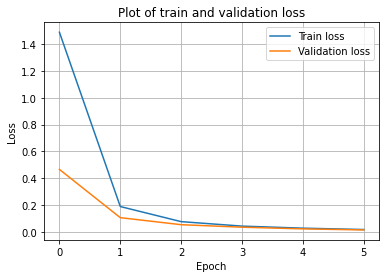

In [38]:
plt.plot(hist["loss"], label="Train loss")
plt.plot(hist["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Plot of train and validation loss")
plt.grid()
plt.show()

In [39]:
# Predict output for test data
test_pred = model.predict(x_test, verbose=1)
# Index as key and tag as value
idx_to_tag = {i: w for w, i in tag_to_idx.items()}
# Function to convert indexed tags to corresponding actual tags
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx_to_tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("Accuracy: ", accuracy_score(test_labels, pred_labels))

9592/9592 [==============================] - 51s 5ms/step
Accuracy:  0.9884492285237698


In [40]:
from future.utils import iteritems
tags = list(set(data["Tag"].values))
number_tags = len(tags)

tag2idx = {t: i+1 for i, t in enumerate(tags)}
idx2tag = {i: w for w, i in iteritems(tag2idx)}

In [41]:
#Evaluating the model
from sklearn.metrics import classification_report
y_pred = model.predict(np.array(x_test))  
print(classification_report(np.argmax(y_test, 2).ravel(), 
                            np.argmax(y_pred, axis=2).ravel(),
                            labels=list(idx2tag.keys()), 
                            target_names=list(idx2tag.values())))

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00      4077
       B-tim       0.00      0.00      0.00      3142
       B-gpe       0.00      0.00      0.00        13
       I-nat       0.54      0.28      0.37      3394
       I-org       0.57      0.10      0.18      4151
       B-org       0.00      0.00      0.00      1251
       I-tim       1.00      1.00      1.00   1886160
           O       0.00      0.00      0.00        84
       I-art       0.00      0.00      0.00        40
       B-nat       0.53      0.79      0.63      3406
       I-per       0.00      0.00      0.00        65
       I-eve       0.42      0.20      0.27      1462
       I-geo       0.00      0.00      0.00        33
       I-gpe       0.00      0.00      0.00        70
       B-eve       0.43      0.71      0.53      7558
       B-geo       0.47      0.52      0.50      3400
       B-per       0.00      0.00      0.00         0

   micro avg       0.99   